# 3 - 通过联合学习对齐和翻译实现神经机器翻译

在这个使用Mindspore的序列到序列模型的第三个笔记本中，我们将实现来自[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)的模型。与先前模型相比，该模型实现了我们迄今为止的最佳困惑度。

## 简介

作为提醒，这是一般的编码器-解码器模型：

![](assets/seq2seq1.png)

在先前的模型中，我们的架构被设置为通过在每个时间步将上下文向量$z$明确传递给解码器，并通过在每个时间步将上下文向量和嵌入的输入词$d(y_t)$以及隐藏状态$s_t$传递给线性层$f$来减少“信息压缩”。

![](assets/seq2seq7.png)

即使我们减少了一些这种压缩，我们的上下文向量仍然需要包含有关源句的所有信息。本笔记本中实现的模型通过允许解码器在每个解码步骤中查看整个源句（通过其隐藏状态）来避免此压缩！它是如何做到这一点的呢？它使用*注意力*。

注意力通过首先计算一个与源句长度相同的注意力向量$a$来工作。注意向量具有每个元素都在0到1之间的属性，并且整个向量总和为1。然后，我们计算我们的源句隐藏状态$H$的加权和，以获得加权源向量$w$。

$$w = \sum_{i}a_ih_i$$

在解码时，我们在每个时间步计算一个新的加权源向量，将其用作解码器RNN的输入，以及用于进行预测的线性层。我们将在教程中解释如何完成所有这些。

## 准备数据

再次，准备工作与上次相似。

首先，导入所有所需的模块。


In [1]:
import mindspore as ms
import mindspore.context as context
import mindspore.nn as nn
import mindspore.ops as ops

import random
import numpy as np
import spacy
import datasets
from tqdm.notebook import tqdm
import evaluate
from matplotlib import pyplot as plt

设置随机数种子

In [2]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
ms.set_seed(seed)

加载数据集

In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")

Found cached dataset json (/root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
train_data, valid_data, test_data = dataset["train"], dataset["validation"], dataset["test"]

In [5]:
en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

In [6]:
def tokenize_example(
    example,
    en_nlp,
    de_nlp,
    max_length,
    lower,
    sos_token,
    eos_token
):
    en_tokens = [token.text for token in en_nlp.tokenizer(example["en"])][:max_length]
    de_tokens = [token.text for token in de_nlp.tokenizer(example["de"])][:max_length]
    if lower:
        en_tokens = [token.lower() for token in en_tokens]
        de_tokens = [token.lower() for token in de_tokens]
    en_tokens = [sos_token] + en_tokens + [eos_token]
    de_tokens = [sos_token] + de_tokens + [eos_token]
    return {"en_tokens": en_tokens, "de_tokens": de_tokens}

In [7]:
max_length = 1_000
lower = True
sos_token = "<sos>"
eos_token = "<eos>"

fn_kwargs = {
    "en_nlp": en_nlp, 
    "de_nlp": de_nlp, 
    "max_length": max_length,
    "lower": lower,
    "sos_token": sos_token,
    "eos_token": eos_token,
}


train_data = train_data.map(tokenize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(tokenize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(tokenize_example, fn_kwargs=fn_kwargs)

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-39e2a81dd5826464.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-340eed13fdfe768e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-05a87c7dda3754fe.arrow


In [8]:
import collections
class Vocab:
    """一个词汇表的实现"""
    def __init__(self, tokens:list, min_freq=0, reserved_tokens:list=None) -> None:
        self.default_index = None
        if tokens is not None:
            # 当第一个条件满足时，就不会跳到第二个判断，避免了空列表报错的情况。
            if len(tokens)!=0 and isinstance(tokens[0], list):
                tokens = [i for line in tokens for i in line]
        else:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter=collections.Counter(tokens)
        # 按出现词频从高到低排序
        self._token_freqs = sorted(counter.items(), key=lambda x:x[1], reverse=True)
        # 通过列表,利用序号访问词元。
        self.idx_to_token = [] + reserved_tokens # 未知词元<unk>的索引为0, 保留词元排在最前
        self.token_to_idx = {
            i: k
            for k, i in enumerate(self.idx_to_token) 
        }
        
        for token, freq in self._token_freqs:
            if freq < min_freq:  # 过滤掉出现频率低于要求的词
                break
            if token not in self.token_to_idx:  
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, input_tokens):
        """输入单字串或序列, 将其全部转化为序号编码"""
        if isinstance(input_tokens, str):
            out =  self.token_to_idx.get(input_tokens, self.default_index)
            if out is None:
                raise Exception('Please call "set_default_index" before getting unknown index')
            return out
        return [self.__getitem__(token) for token in input_tokens]
    
    def __repr__(self) -> str:
        show_items = 5 if len(self) > 5 else len(self)
        out = f"<Vocab with {len(self)} tokens: "
        for i in range(show_items):
            out += f'"{self.idx_to_token[i]}", '
        out += "...>"
        return out

    def __contains__(self, token:str) -> bool:
        return token in self.idx_to_token

    def to_tokens(self, input_keys):
        """输入单s索引或序列, 将其全部转化为词元"""
        if isinstance(input_keys, int):
            return self.idx_to_token[input_keys] if input_keys < len(self) else self.idx_to_token[0]
        elif isinstance(input_keys, (list, tuple)):
            return [self.to_tokens(keys) for keys in input_keys]
        else:
            return self.idx_to_token[0]
    
    def get_itos(self):
        return self.idx_to_token
    
    def get_stoi(self):
        return self.token_to_idx
    
    def set_default_index(self, idx):
        if isinstance(idx, int):
            self.default_index = idx
        else:
            raise Exception(f"Only type int allowed, got {type(idx)}")

    def lookup_indices(self, input_tokens):
        return self.__getitem__(input_tokens)
    
    def lookup_tokens(self, idx):
        return self.to_tokens(idx)

In [9]:
min_freq = 2
unk_token = "<unk>"
pad_token = "<pad>"

special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

def build_vocab_from_iterator(tokens, min_freq, specials):
    return Vocab(tokens, min_freq, specials)

en_vocab = build_vocab_from_iterator(
    train_data["en_tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

de_vocab = build_vocab_from_iterator(
    train_data["de_tokens"],
    min_freq=min_freq,
    specials=special_tokens,  
)

In [10]:
assert en_vocab[unk_token] == de_vocab[unk_token]
assert en_vocab[pad_token] == de_vocab[pad_token]

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

In [11]:
en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)

In [12]:
def numericalize_example(example, en_vocab, de_vocab):
    en_ids = en_vocab.lookup_indices(example["en_tokens"])
    de_ids = de_vocab.lookup_indices(example["de_tokens"])
    return {"en_ids": en_ids, "de_ids": de_ids}

In [13]:
fn_kwargs = {
    "en_vocab": en_vocab, 
    "de_vocab": de_vocab
}

train_data = train_data.map(numericalize_example, fn_kwargs=fn_kwargs)
valid_data = valid_data.map(numericalize_example, fn_kwargs=fn_kwargs)
test_data = test_data.map(numericalize_example, fn_kwargs=fn_kwargs)

Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-6689c04abfdb721f.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-acab783df695b18d.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/bentrevett___json/bentrevett--multi30k-8cca6da32304eb4d/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-e1088b8589007c26.arrow


In [14]:
data_type = "numpy"
format_columns = ["en_ids", "de_ids"]

train_data = train_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True
)

valid_data = valid_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

test_data = test_data.with_format(
    type=data_type, 
    columns=format_columns, 
    output_all_columns=True,
)

In [15]:
def pad_sequence(sequences:list, padding_value:int):
    '''将序列填充到等长并返回mindspore张量'''
    # Find the length of the longest sequence in the batch
    max_length = max(len(seq) for seq in sequences)
    padded_sequences:ms.Tensor = ops.full((len(sequences), max_length), padding_value, dtype=ms.int64)
    # Copy the sequences into the padded array
    for i, seq in enumerate(sequences):
        padded_sequences[i, :len(seq)] = ms.tensor(seq).astype(np.int64)
    # 换轴，保证输出为时序优先
    padded_sequences = padded_sequences.swapaxes(0, 1)
    return padded_sequences  

def get_collate_fn(pad_index):
    
    def collate_fn(batch):
        batch_en_ids = [example["en_ids"] for example in batch]
        batch_de_ids = [example["de_ids"] for example in batch]
        batch_en_ids = pad_sequence(batch_en_ids, padding_value=pad_index)
        batch_de_ids = pad_sequence(batch_de_ids, padding_value=pad_index)
        batch = {
            "en_ids": batch_en_ids,
            "de_ids": batch_de_ids,
        }
        return batch
    
    return collate_fn

In [16]:
class DataLoader:
    def __init__(self, source, batch_size, shuffle=False, per_batch_map=None):
        self.source = source
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.per_batch_map = per_batch_map
        self.indices = np.arange(len(source))
        self.current_index = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self):
        if self.current_index >= len(self.source):
            self.current_index = 0
            raise StopIteration

        batch_indices = self.indices[self.current_index:self.current_index + self.batch_size]
        batch_data = [self.source[int(i)] for i in batch_indices]

        if self.per_batch_map:
            batch_data = self.per_batch_map(batch_data)

        self.current_index += self.batch_size
        return batch_data
    
    def __len__(self):
        return len(self.source) // self.batch_size


def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    dataloader = DataLoader(dataset, batch_size, shuffle=shuffle, per_batch_map=collate_fn)
    
    return dataloader

In [17]:
batch_size = 128

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

## 构建Seq2Seq模型

### 编码器

首先，我们将构建编码器。与之前的模型类似，我们仅使用一个单层GRU，但现在我们使用了*双向RNN*。在双向RNN中，每一层都有两个RNN。一个*RNN向前*从左到右遍历嵌入的句子（下图中为绿色），一个*RNN向后*从右到左遍历嵌入的句子（青色）。在代码中，我们只需设置 `bidirectional = True`，然后像以前一样将嵌入的句子传递给RNN。

![](assets/seq2seq8.png)

现在我们有：

$$\begin{align*}
h_t^\rightarrow &= \text{EncoderGRU}^\rightarrow(e(x_t^\rightarrow),h_{t-1}^\rightarrow)\\
h_t^\leftarrow &= \text{EncoderGRU}^\leftarrow(e(x_t^\leftarrow),h_{t-1}^\leftarrow)
\end{align*}$$

其中 $x_0^\rightarrow = \text{<sos>}, x_1^\rightarrow = \text{guten}$ 和 $x_0^\leftarrow = \text{<eos>}, x_1^\leftarrow = \text{morgen}$。

与之前一样，我们只将输入 (`embedded`) 传递给RNN，告诉Mindspore将前向和后向初始隐藏状态（分别为 $h_0^\rightarrow$ 和 $h_0^\leftarrow$）初始化为全零张量。我们还会得到两个上下文向量，一个来自前向RNN在看到句子的最后一个词后，$z^\rightarrow=h_T^\rightarrow$，一个来自后向RNN在看到句子的第一个词后，$z^\leftarrow=h_T^\leftarrow$。

RNN返回 `outputs` 和 `hidden`。

`outputs` 的大小为 **[src len, batch size, hid dim * num directions]**，其中第三轴的前 `hid_dim` 元素是从顶层前向RNN获得的隐藏状态，最后的 `hid_dim` 元素是从顶层后向RNN获得的隐藏状态。我们可以将第三轴视为前向和后向隐藏状态在一起连接的地方，即 $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$，$h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$，我们可以将所有编码器隐藏状态（前向和后向连接在一起）表示为 $H=\{ h_1, h_2, ..., h_T\}$。

`hidden` 的大小为 **[n layers * num directions, batch size, hid dim]**，其中 **[-2, :, :]** 给出了顶层前向RNN在最后一个时间步（即在看到句子的最后一个词后）之后的隐藏状态，**[-1, :, :]** 给出了顶层后向RNN在最后一个时间步（即在看到句子的第一个词后）之后的隐藏状态。

由于解码器不是双向的，它只需要一个上下文向量 $z$ 用作初始隐藏状态 $s_0$，而我们目前有两个，一个前向的和一个后向的（$z^\rightarrow=h_T^\rightarrow$ 和 $z^\leftarrow=h_T^\leftarrow$）。我们通过将两个上下文向量连接在一起，将它们传递给一个线性层 $g$ 并应用 $\tanh$ 激活函数来解决这个问题。

$$z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$$

**注意**：这实际上是与论文中的方法有所不同。在论文中，他们仅通过线性层传递第一个后向RNN隐藏状态以获得上下文向量/解码器初始隐藏状态。这对我来说看起来不合理，所以我们进行了修改。

由于我们希望我们的模型能够查看整个源句子，我们返回 `outputs`，即源句子中每个标记的堆叠的前向和后向隐藏状态。我们还返回 `hidden`，它充当解码器中的初始隐藏状态。


In [18]:
class Encoder(nn.Cell):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        self.fc = nn.Dense(enc_hid_dim * 2, dec_hid_dim)
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, src):
        
        #src = [src len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = ops.tanh(self.fc(ops.cat((hidden[-2,:,:], hidden[-1,:,:]), axis=1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

接下来是注意力层。它将接收到解码器的前一个隐藏状态 $s_{t-1}$ 和编码器的所有堆叠的前向和后向隐藏状态 $H$。该层将输出一个注意力向量 $a_t$，其长度为源句子的长度，其中每个元素在 0 和 1 之间，整个向量的和为 1。

直观地说，该层利用我们到目前为止已解码的内容 $s_{t-1}$ 和我们已编码的所有内容 $H$ 来生成一个向量 $a_t$，该向量表示为了正确预测下一个要解码的单词 $\hat{y}_{t+1}$，我们应该最关注源句子中的哪些单词。

首先，我们计算前一个解码器隐藏状态和编码器隐藏状态之间的 *能量*。由于我们的编码器隐藏状态是 $T$ 个张量的序列，而我们的前一个解码器隐藏状态是单个张量，我们首先使用 `repeat` 将前一个解码器隐藏状态重复 $T$ 次。然后，通过将它们连接在一起并通过一个线性层 (`attn`) 和一个 $\tanh$ 激活函数，计算它们之间的能量 $E_t$。

$$E_t = \tanh(\text{attn}(s_{t-1}, H))$$

这可以看作是计算每个编码器隐藏状态与前一个解码器隐藏状态的 "匹配程度"。

我们目前对于批处理中的每个示例都有一个 **[dec hid dim, src len]** 张量。我们希望对于批处理中的每个示例，这个张量都是 **[src len]**，因为注意力应该覆盖源句子的长度。这通过将 `energy` 乘以 **[1, dec hid dim]** 张量 $v$ 来实现。

$$\hat{a}_t = v E_t$$

我们可以将 $v$ 视为加权求和的权重，这个权重遍历所有编码器隐藏状态的能量。这些权重告诉我们在源序列中应该注意每个标记的程度。 $v$ 的参数是随机初始化的，但会随着模型的其余部分一起通过反向传播进行学习。请注意，$v$ 不依赖于时间，并且在解码的每个时间步骤中都使用相同的 $v$。我们将 $v$ 实现为一个没有偏差的线性层。

最后，通过通过一个 $\text{softmax}$ 层，我们确保注意力向量符合所有元素都在 0 和 1 之间且向量总和为 1 的约束。

$$a_t = \text{softmax}(\hat{a_t})$$

这给我们提供了源句子上的注意力！

从图形上看，如下所示。这是用于计算第一个注意力向量的情况，其中 $s_{t-1} = s_0 = z$。绿色/青色块表示前向和后向RNN的隐藏状态，注意力计算完全在粉色块内完成。

![](assets/seq2seq9.png)


In [19]:
class Attention(nn.Cell):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Dense((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Dense(dec_hid_dim, 1, has_bias = False)
        
    def construct(self, hidden:ms.Tensor, encoder_outputs:ms.Tensor):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).tile((1, src_len, 1))
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = ops.tanh(self.attn(ops.cat((hidden, encoder_outputs), axis = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        return ops.softmax(attention, axis=1)

### Decoder

接下来是解码器。

解码器包含注意力层 `attention`，该层接收前一个隐藏状态 $s_{t-1}$，所有编码器隐藏状态 $H$，并返回注意力向量 $a_t$。

然后，我们使用这个注意力向量来创建加权源向量 $w_t$，表示为 `weighted`，它是使用 $a_t$ 作为权重对编码器隐藏状态 $H$ 进行加权求和。

$$w_t = a_t H$$

嵌入的输入单词 $d(y_t)$、加权源向量 $w_t$ 和前一个解码器隐藏状态 $s_{t-1}$ 随后都传入解码器 RNN，其中 $d(y_t)$ 和 $w_t$ 被连接在一起。

$$s_t = \text{DecoderGRU}(d(y_t), w_t, s_{t-1})$$

然后，我们通过线性层 $f$ 传递 $d(y_t)$、$w_t$ 和 $s_t$，以预测目标句子中的下一个单词 $\hat{y}_{t+1}$。这通过将它们全部连接在一起来实现。

$$\hat{y}_{t+1} = f(d(y_t), w_t, s_t)$$

下图显示了对示例翻译中的第一个单词进行解码。

![](assets/seq2seq10.png)

绿色/青色块显示了前向/后向编码器RNN，其输出为 $H$；红色块显示了上下文向量 $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$；蓝色块显示了解码器RNN，其输出为 $s_t$；紫色块显示了线性层 $f$，其输出为 $\hat{y}_{t+1}$；橙色块显示了通过 $a_t$ 对 $H$ 进行加权求和的计算，并输出 $w_t$。没有显示 $a_t$ 的计算。


In [20]:
class Decoder(nn.Cell):
    def __init__(self, output_dim:int, emb_dim:int, enc_hid_dim:int, dec_hid_dim:int, dropout, attention:Attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Dense((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(p=dropout)
        
    def construct(self, input:ms.Tensor, hidden:ms.Tensor, encoder_outputs:ms.Tensor):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = ops.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = ops.cat((embedded, weighted), axis = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(ops.cat((output, weighted, embedded), axis = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

这是第一个不需要使编码器RNN和解码器RNN具有相同隐藏维度的模型，但是编码器必须是双向的。可以通过将所有出现的 `enc_dim * 2` 更改为 `enc_dim * 2 if encoder_is_bidirectional else enc_dim` 来移除此要求。

这个seq2seq封装器与前两个类似。唯一的区别是 `encoder` 返回最终隐藏状态（即从前向和后向编码器RNN传递过线性层的最终隐藏状态），用作解码器的初始隐藏状态，以及每个隐藏状态（即前向和后向隐藏状态堆叠在一起）。我们还需要确保将 `hidden` 和 `encoder_outputs` 传递给解码器。

简要概述所有步骤：
- 创建 `outputs` 张量以保存所有预测 $\hat{Y}$
- 将源序列 $X$ 输入编码器以接收 $z$ 和 $H$
- 将初始解码器隐藏状态设置为 `context` 向量，$s_0 = z = h_T$
- 使用一批 `<sos>` 标记作为第一个 `input`，$y_1$
- 然后在循环内解码：
  - 将输入标记 $y_t$、前一个隐藏状态 $s_{t-1}$ 和所有编码器输出 $H$ 插入解码器
  - 接收预测 $\hat{y}_{t+1}$ 和新的隐藏状态 $s_t$
  - 然后决定是否使用 teacher force，设置下一个输入为适当的值


In [21]:
class Seq2Seq(nn.Cell):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder:Encoder = encoder
        self.decoder:Decoder = decoder
        
    def construct(self, src:ms.Tensor, trg:ms.Tensor, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        # outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        outputs = []
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            #insert input token embedding, previous hidden state and all encoder hidden states
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            if len(outputs) == 0:
                outputs.append(ops.zeros(output.shape, dtype=output.dtype))
            #place predictions in a tensor holding predictions for each token
            # outputs[t] = output
            outputs.append(output)
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            if self.training:
                teacher_force = random.random() < teacher_forcing_ratio
                # get the highest predicted token from our predictions
                
                # if teacher forcing, use actual next token as next input
                # if not, use predicted token
                input = trg[t] if teacher_force else top1
                # input = [batch size]
            else:
                input = top1
        # return outputs
        return ops.stack(outputs, axis=0)

In [22]:
input_dim = len(de_vocab)
output_dim = len(en_vocab)
encoder_embedding_dim = 256
decoder_embedding_dim = 256
encoder_hidden_dim = 512
decoder_hidden_dim = 512
encoder_dropout = 0.5
decoder_dropout = 0.5

attention = Attention(encoder_hidden_dim, decoder_hidden_dim)

encoder = Encoder(
    input_dim,
    encoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    encoder_dropout,
)

decoder = Decoder(
    output_dim,
    decoder_embedding_dim,
    encoder_hidden_dim,
    decoder_hidden_dim,
    decoder_dropout,
    attention,
)


model = Seq2Seq(encoder, decoder)

In [39]:
def init_weights(m:nn.Cell):
    for name, param in m.parameters_and_names():
        if "weight" in name:
            param.set_data(ops.normal(param.shape, ms.Tensor([0.]), ms.Tensor([0.01])))
        else:
            param.set_data(ops.zeros(param.shape, dtype=param.dtype))

model.apply(init_weights)

Seq2Seq<
  (encoder): Encoder<
    (embedding): Embedding<vocab_size=7853, embedding_size=256, use_one_hot=False, embedding_table=Parameter (name=encoder.embedding.embedding_table, shape=(7853, 256), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
    (rnn): GRU<
      (rnn): _DynamicGRUCPUGPU<>
      (dropout_op): Dropout<p=0.0>
      >
    (fc): Dense<input_channels=1024, output_channels=512, has_bias=True>
    (dropout): Dropout<p=0.5>
    >
  (decoder): Decoder<
    (attention): Attention<
      (attn): Dense<input_channels=1536, output_channels=512, has_bias=True>
      (v): Dense<input_channels=512, output_channels=1>
      >
    (embedding): Embedding<vocab_size=5893, embedding_size=256, use_one_hot=False, embedding_table=Parameter (name=decoder.embedding.embedding_table, shape=(5893, 256), dtype=Float32, requires_grad=True), dtype=Float32, padding_idx=None>
    (rnn): GRU<
      (rnn): _DynamicGRUCPUGPU<>
      (dropout_op): Dropout<p=0.0>
      >
    (fc_o

In [40]:
def count_parameters(model):
    return sum(p.numel() for p in model.get_parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,518,405 trainable parameters


In [41]:
optimizer = nn.Adam(model.trainable_params())

In [26]:
criterion = nn.CrossEntropyLoss(ignore_index=pad_index)

In [43]:
def forward_fn(src, trg, teacher_forcing_ratio):
    # src = [src length, batch size]
    # trg = [trg length, batch size]
    output = model(src, trg, teacher_forcing_ratio)
    # output = [trg length, batch size, trg vocab size]
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim)
    # output = [(trg length - 1) * batch size, trg vocab size]
    trg = trg[1:].view(-1)
    # trg = [(trg length - 1) * batch size]
    loss = criterion(output, trg.astype(ms.int32))
    return loss

grad_fn = ms.value_and_grad(forward_fn, grad_position=None, weights=model.trainable_params())


def train_fn(data_loader, optimizer, clip, teacher_forcing_ratio):
    epoch_loss = 0.
    model.set_train(True)
    for i, batch in enumerate(tqdm(data_loader)):
        src = batch["de_ids"]
        trg = batch["en_ids"]
        loss, grads = grad_fn(src, trg, teacher_forcing_ratio)
        # grads = ops.clip_by_norm(grads, max_norm=clip)
        optimizer(grads)
        epoch_loss += float(loss)

    return epoch_loss / len(data_loader)

In [24]:
def evaluate_fn(model:Seq2Seq, data_loader, criterion):
    epoch_loss = 0
    model.set_train(False)
    for i, batch in enumerate(data_loader):
        src = batch["de_ids"]
        trg = batch["en_ids"]
        # src = [src length, batch size]
        # trg = [trg length, batch size]
        output = model(src, trg, 0) # turn off teacher forcing
        # output = [trg length, batch size, trg vocab size]
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        # output = [(trg length - 1) * batch size, trg vocab size]
        trg = trg[1:].view(-1)
        # trg = [(trg length - 1) * batch size]
        loss = criterion(output, trg.astype(ms.int32))
        epoch_loss += float(loss)
    return epoch_loss / len(data_loader)

In [45]:
n_epochs = 10
clip = 1.0
teacher_forcing_ratio = 0.5

best_valid_loss = float("inf")

for epoch in tqdm(range(n_epochs)):
        
    train_loss = train_fn(
        train_data_loader, 
        optimizer, 
        clip, 
        teacher_forcing_ratio, 
    )
    
    valid_loss = evaluate_fn(
        model, 
        valid_data_loader, 
        criterion, 
    )

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        ms.save_checkpoint(model, f"./tut3-model.ckpt")
    
    print(f"\tTrain Loss: {train_loss:7.3f} | Train PPL: {np.exp(train_loss):7.3f}")
    print(f"\tValid Loss: {valid_loss:7.3f} | Valid PPL: {np.exp(valid_loss):7.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   5.147 | Train PPL: 171.917
	Valid Loss:   5.657 | Valid PPL: 286.161


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   4.415 | Train PPL:  82.654
	Valid Loss:   5.374 | Valid PPL: 215.730


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   4.082 | Train PPL:  59.263
	Valid Loss:   5.066 | Valid PPL: 158.580


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   3.625 | Train PPL:  37.507
	Valid Loss:   4.516 | Valid PPL:  91.457


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   3.090 | Train PPL:  21.984
	Valid Loss:   4.117 | Valid PPL:  61.348


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   2.668 | Train PPL:  14.413
	Valid Loss:   3.962 | Valid PPL:  52.537


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   2.379 | Train PPL:  10.796
	Valid Loss:   3.785 | Valid PPL:  44.028


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   2.100 | Train PPL:   8.164
	Valid Loss:   3.870 | Valid PPL:  47.959


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   1.889 | Train PPL:   6.616
	Valid Loss:   3.879 | Valid PPL:  48.373


  0%|          | 0/226 [00:00<?, ?it/s]

	Train Loss:   1.715 | Train PPL:   5.558
	Valid Loss:   3.869 | Valid PPL:  47.904


In [27]:
ms.load_checkpoint(f"tut3-model.ckpt", model)

test_loss = evaluate_fn(model, test_data_loader, criterion)

print(f"| Test Loss: {test_loss:.3f} | Test PPL: {np.exp(test_loss):7.3f} |")

| Test Loss: 3.739 | Test PPL:  42.069 |


我们改进了之前的模型，但代价是训练时间翻倍!


## 模型评估
### 翻译与可视化

我们首先需要使用模型翻译测试集的每个例子，我们使用下面的 `translate_sentence` 函数来实现这一点。
## 推断

我们的 `translate_sentence` 将执行以下操作：
- 确保我们的模型处于评估模式，对于推断来说，它应该一直是这样的
- 如果源句子没有被标记，则对其进行标记
- 数字化源句子
- 将其转换为张量并添加一个批次维度
- 获取源句子的长度并转换为张量
- 将源句子输入到编码器中
- 创建一个列表来保存输出句子，初始化为 `<sos>` token
- 创建一个张量来保存 attention 值
- 当我们尚未达到最大长度时
  - 获取输入张量，应该是 `<sos>` 或最后预测的 token
  - 将输入、所有编码器输出、隐藏状态和 mask 传递到解码器中
  - 存储 attention 值
  - 获取下一个预测的 token
  - 将预测添加到当前输出句子预测中
  - 如果预测是 `<eos>` token，则中断
- 将输出句子从索引转换为 token
- 返回输出句子（去除 `<sos>` token）和对整个序列的 attention 值


In [28]:
def translate_sentence(
    sentence, 
    model:Seq2Seq,
    en_nlp:spacy.Language,
    de_nlp:spacy.Language,
    en_vocab:Vocab,
    de_vocab:Vocab,
    lower,
    sos_token,
    eos_token,
    max_output_length=25,
):
    model.set_train(False)
    if isinstance(sentence, str):
        tokens = [token.text for token in de_nlp.tokenizer(sentence)]
    else:
        tokens = [token for token in sentence]
    if lower:
        tokens = [token.lower() for token in tokens]
    tokens = [sos_token] + tokens + [eos_token]
    ids = de_vocab.lookup_indices(tokens)

    tensor = ms.Tensor(ids).astype(ms.int64).unsqueeze(-1)
    encoder_outputs, hidden = model.encoder(tensor)
    
    inputs = en_vocab.lookup_indices([sos_token])
    attentions = ops.zeros((max_output_length, 1, len(ids)))
    for i in range(max_output_length):
        inputs_tensor = ms.Tensor(inputs[-1]).unsqueeze(-1).astype(ms.int64)
        
        output, hidden, attention = model.decoder(inputs_tensor, hidden, encoder_outputs)
        attentions[i] = attention
        predicted_token = output.argmax(-1).item()
        inputs.append(int(predicted_token))
        if predicted_token == en_vocab[eos_token]:
            break
    en_tokens = en_vocab.lookup_tokens(inputs)
    return en_tokens, tokens, attentions[:len(en_tokens)-1]

这段代码用于绘制注意力矩阵的可视化图。展示模型在翻译时对输入句子的注意力分布。横轴表示输入句子的词汇，纵轴表示翻译结果的词汇，而颜色的深浅表示不同位置的注意力权重。这样的图可以帮助我们理解模型在翻译时的关注点。

In [29]:
def plot_attention(sentence, translation, attention:Attention):
    fig, ax = plt.subplots(figsize=(10,10))
    attention = attention.squeeze(1).numpy()
    cax = ax.matshow(attention, cmap="bone")
    ax.set_xticks(ticks=np.arange(len(sentence)), labels=sentence, rotation=90, size=15)
    translation = translation[1:]
    ax.set_yticks(ticks=np.arange(len(translation)), labels=translation, size=15)
    plt.show()
    plt.close()

In [30]:
sentence = test_data[0]["de"]
expected_translation = test_data[0]["en"]

sentence, expected_translation

('Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.',
 'A man in an orange hat starring at something.')

In [31]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)

In [32]:
translation

['<sos>',
 'a',
 'man',
 'in',
 'an',
 'orange',
 'hat',
 'is',
 'something',
 'to',
 '<unk>',
 '.',
 '<eos>']

In [33]:
sentence_tokens

['<sos>',
 'ein',
 'mann',
 'mit',
 'einem',
 'orangefarbenen',
 'hut',
 ',',
 'der',
 'etwas',
 'anstarrt',
 '.',
 '<eos>']

根据可视化结果可知，模型在翻译时，总是会关注在时序上较为临近的token。

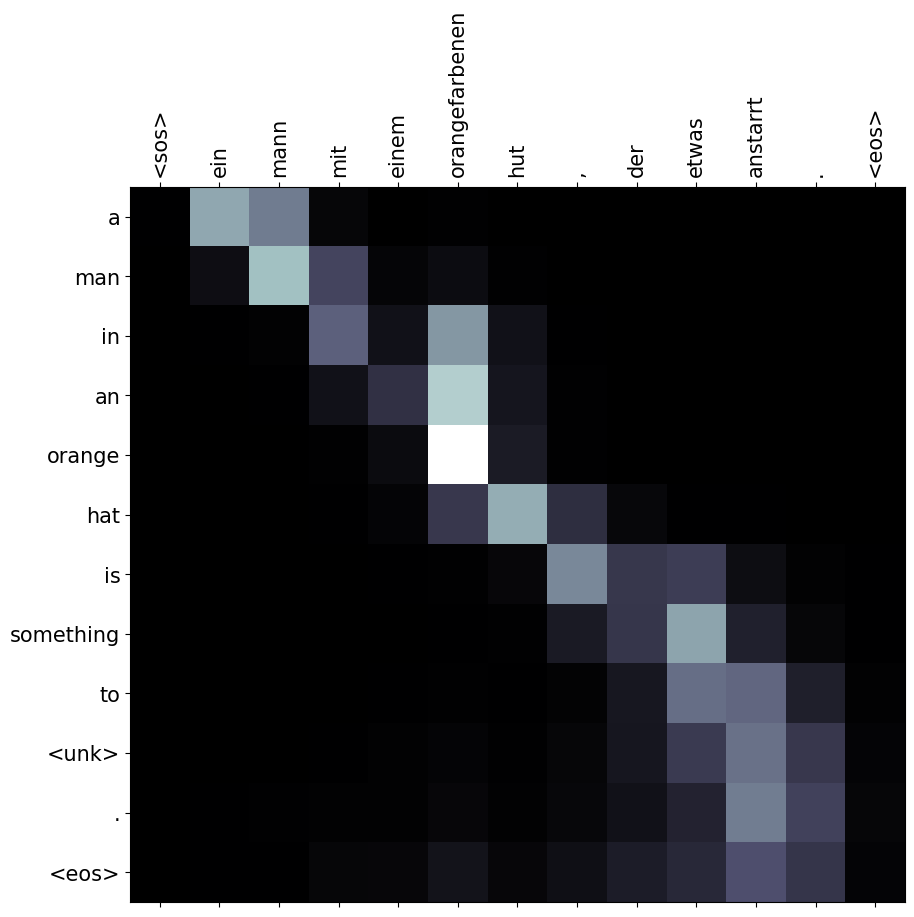

In [34]:
plot_attention(sentence_tokens, translation, attention)

通过将任何字符串传递给 `translate_sentence` 来使用它来翻译任意句子。

In [35]:
sentence = "Ein Mann sieht sich einen Film an."

In [36]:
translation, sentence_tokens, attention = translate_sentence(
    sentence,
    model,
    en_nlp,
    de_nlp,
    en_vocab,
    de_vocab,
    lower,
    sos_token,
    eos_token,
)

In [37]:
translation

['<sos>', 'a', 'man', 'looking', 'at', 'a', 'a', '.', '<eos>']

通过注意力也可以发现，翻译出现错误的位置，其注意力也较为弥散。

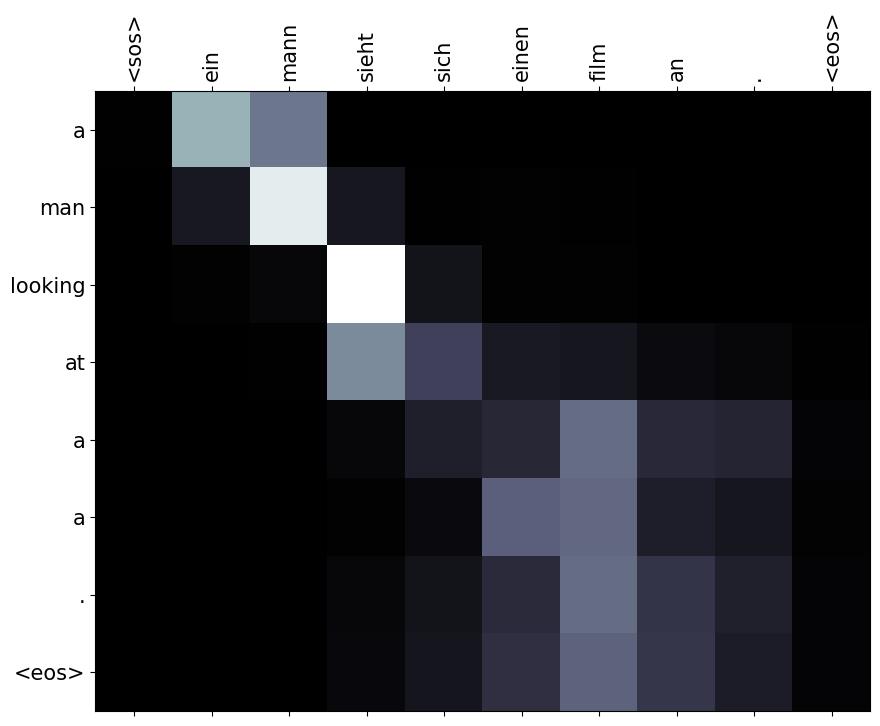

In [38]:
plot_attention(sentence_tokens, translation, attention)

循环遍历我们的 `test_data`，得到模型对每个测试句子的翻译。

In [40]:
translations = [
    translate_sentence(
        example["de"],
        model,
        en_nlp,
        de_nlp,
        en_vocab,
        de_vocab,
        lower,
        sos_token,
        eos_token, 
    )[0] for example in tqdm(test_data)
]

  0%|          | 0/1000 [00:00<?, ?it/s]

### 评估`bleu`指标
从`evaluate`库中加载BLEU指标：

In [41]:
bleu = evaluate.load("bleu")

将目标句子放入列表中。并将我们的翻译从token列表转换为字符串，方法是在它们之间用空格连接，并摆脱`<sos>`和`<eos>`tocken。

In [42]:
predictions = [
    " ".join(translation[1:-1]) for translation in translations
]

references = [
    [example["en"]] for example in test_data
]

定义一个函数，该函数对输入字符串进行tocken化。通过将我们的预测tocken与参考tocken进行比较来计算BLEU分数。

In [43]:
def get_tokenizer_fn(nlp, lower):
    
    def tokenizer_fn(s):
        tokens = [token.text for token in nlp.tokenizer(s)]
        if lower:
            tokens = [token.lower() for token in tokens]
        return tokens
        
    return tokenizer_fn

In [44]:
tokenizer_fn = get_tokenizer_fn(en_nlp, lower)

最后，我们在测试集上计算BLEU指标！

我们将我们的“predictions”、“references”和我们的“tokenizer_fn”传递给BLEU指标的“compute”方法，以获取我们的结果。

In [45]:
results = bleu.compute(predictions=predictions, references=references, tokenizer=tokenizer_fn)

In [46]:
results

{'bleu': 0.2633405950067028,
 'precisions': [0.5873529411764706,
  0.3334920634920635,
  0.19836206896551725,
  0.12377358490566037],
 'brevity_penalty': 1.0,
 'length_ratio': 1.0415071220707612,
 'translation_length': 13600,
 'reference_length': 13058}

我们获得了0.263的BLEU分数, 但是训练的时间也翻倍了。


通过方法的进步，可以逐渐提高BLEU分数！


在下一个笔记本中，我们将使用相同的架构，但使用适用于所有 RNN 架构的一些技巧 - packed padded sequences 和 masking。我们还将实现一些代码，让我们查看 RNN 在解码输出时关注的输入单词。